## JAX Setup
Code adapted from [JAX examples](https://github.com/google/jax/blob/master/examples/mnist_classifier.py).

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import itertools
from typing import Sequence

import numpy.random as npr

import jax.numpy as jnp
import numpy as np
# from jax.config import config

# from jax import jit, grad, random
import jax

# from jax.experimental import optimizers
import optax

# stax is dead, long live flax
# from jax.experimental import stax
# from jax.experimental.stax import Dense, Relu, LogSoftmax, BatchNorm
import flax.linen as nn


import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


# used for tensorflow datasets
import tensorflow as tf
# tf.enable_eager_execution()
tf.executing_eagerly()


True

## MNIST Setup

In [2]:
rng = jax.random.PRNGKey(0)

# step_size = 0.001
N_EPOCHS = 3
BATCH_SIZE = 128
# momentum_mass = 0.9
LEARNING_RATE = 0.002

NUM_CLASSES = 10

In [3]:
#load mnist
# train_ds = tfds.load("mnist", split=tfds.Split.TRAIN, batch_size=-1)
# numpy_ds = tfds.as_numpy(train_ds)
# numpy_images, numpy_labels = numpy_ds["image"], numpy_ds["label"]
# numpy_images.shape, numpy_labels.shape
# train_images = numpy_images[:,:,:,0].reshape(-1, 28*28).astype(jnp.float32)/255.0
# train_labels = jnp.eye(NUM_CLASSES)[numpy_labels]


# test_ds = tfds.load("mnist", split=tfds.Split.TEST, batch_size=-1)
# numpy_ds = tfds.as_numpy(test_ds)
# numpy_images, numpy_labels = numpy_ds["image"], numpy_ds["label"]
# numpy_images.shape, numpy_labels.shape
# test_images = numpy_images[:,:,:,0].reshape(-1, 28*28).astype(jnp.float32)/255.0
# test_labels = jnp.eye(NUM_CLASSES)[numpy_labels]
# print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

# plt.imshow(train_images[0].reshape(28,28))
# plt.title(str(train_labels[0]))

# IMG_SIZE = (28, 28)

(train_loader, test_loader), info = tfds.load(
    "mnist", split=["train", "test"], as_supervised=True, with_info=True
)

min_max_rgb = lambda image, label: (tf.cast(image, tf.float32) / 255., label)
train_loader = train_loader.map(min_max_rgb)
test_loader = test_loader.map(min_max_rgb)

NUM_CLASSES = info.features["label"].num_classes
IMG_SIZE = info.features["image"].shape

train_loader_batched = train_loader.shuffle(
    buffer_size=10_000, reshuffle_each_iteration=True
).batch(BATCH_SIZE, drop_remainder=True)

test_loader_batched = test_loader.batch(BATCH_SIZE, drop_remainder=True)

2025-02-14 11:40:36.890788: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-02-14 11:40:36.937109: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Text(0.5, 1.0, '4')

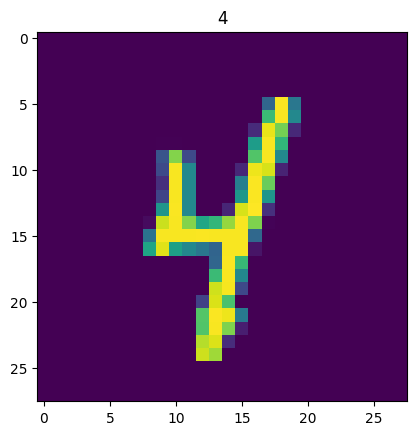

In [4]:
plt.imshow(next(iter(train_loader))[0].numpy().reshape(28, 28))
plt.title(str(next(iter(train_loader))[1].numpy()))

In [5]:
# num_train = train_images.shape[0]
# input_dim = train_images.shape[1]
# num_complete_batches, leftover = divmod(num_train, batch_size)
# num_batches = num_complete_batches + bool(leftover)

In [6]:
# def data_stream():
#   rng = npr.RandomState(0)
#   while True:
#     perm = rng.permutation(num_train)
#     for i in range(num_batches):
#       batch_idx = perm[i * batch_size:(i + 1) * batch_size]
#       yield train_images[batch_idx], train_labels[batch_idx]

# batches = data_stream()

In [7]:
# init_random_params, predict = stax.serial(
#     Dense(1024), Relu,
#     Dense(1024), Relu,
#     Dense(10), LogSoftmax)

class MLP(nn.Module):
  """A simple multilayer perceptron model for image classification."""
  # hidden_sizes: Sequence[int] = (1024, 1024)
  hidden_sizes: Sequence[int] = (1024, 1024)

  @nn.compact
  def __call__(self, x):
    # Flattens images in the batch.
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(features=self.hidden_sizes[0])(x)
    x = nn.relu(x)
    x = nn.Dense(features=self.hidden_sizes[1])(x)
    x = nn.relu(x)
    x = nn.Dense(features=NUM_CLASSES)(x)
    return x

# To initialize the model:
# model = MLP()
# key = jax.random.PRNGKey(42)
# variables = model.init(key, jnp.ones((1, input_dim)))

In [8]:
net = MLP()

@jax.jit
def predict(params, inputs):
  return net.apply({"params": params}, inputs)


@jax.jit
def loss_accuracy(params, data):
  """Computes loss and accuracy over a mini-batch.

  Args:
    params: parameters of the model.
    bn_params: state of the model.
    data: tuple of (inputs, labels).
    is_training: if true, uses train mode, otherwise uses eval mode.

  Returns:
    loss: float
  """
  inputs, labels = data
  logits = predict(params, inputs)
  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits=logits, labels=labels
  ).mean()
  accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
  return loss, {"accuracy": accuracy}

@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

In [9]:
solver = optax.adam(LEARNING_RATE)
rng = jax.random.PRNGKey(0)
dummy_data = jnp.ones((1,) + IMG_SIZE, dtype=jnp.float32)

params = net.init({"params": rng}, dummy_data)["params"]

# scale params to make eigenvalues plot more interesting
# params = jax.tree_map(lambda x: x * 10, params)

solver_state = solver.init(params)

# def dataset_stats(params, data_loader):
#   """Computes loss and accuracy over the dataset `data_loader`."""
#   all_accuracy = []
#   all_loss = []
#   for batch in data_loader.as_numpy_iterator():
#     batch_loss, batch_aux = loss_accuracy(params, batch)
#     all_loss.append(batch_loss)
#     all_accuracy.append(batch_aux["accuracy"])
#   return {"loss": jnp.mean(all_loss), "accuracy": np.mean(all_accuracy)}

def dataset_stats(params, dataloader):
    total_loss = jnp.array(0.)
    total_accuracy = jnp.array(0.)
    count = 0

    for batch in dataloader:
        # Convert TensorFlow tensors to JAX arrays
        images = jnp.array(batch[0])
        labels = jnp.array(batch[1])
        jax_batch = (images, labels)

        batch_loss, batch_aux = loss_accuracy(params, jax_batch)
        total_loss += batch_loss
        total_accuracy += batch_aux["accuracy"]
        count += 1

    return {
        "loss": total_loss / count,
        "accuracy": total_accuracy / count
    }

In [10]:
train_accuracy = []
train_losses = []

# Computes test set accuracy at initialization.
test_stats = dataset_stats(params, test_loader_batched)
test_accuracy = [test_stats["accuracy"]]
test_losses = [test_stats["loss"]]


@jax.jit
def train_step(params, solver_state, batch):
  # Performs a one step update.
  (loss, aux), grad = jax.value_and_grad(loss_accuracy, has_aux=True)(
      params, batch
  )
  updates, solver_state = solver.update(grad, solver_state, params)
  params = optax.apply_updates(params, updates)
  return params, solver_state, loss, aux


for epoch in range(N_EPOCHS):

  train_accuracy_epoch = []
  train_losses_epoch = []

  for step, train_batch in enumerate(train_loader_batched.as_numpy_iterator()):
    params, solver_state, train_loss, train_aux = train_step(
        params, solver_state, train_batch
    )
    train_accuracy_epoch.append(train_aux["accuracy"])
    train_losses_epoch.append(train_loss)
    # if step % 20 == 0:
    #   print(
    #       f"step {step}, train loss: {train_loss:.2e}, train accuracy:"
    #       f" {train_aux['accuracy']:.2f}"
    #   )

  test_stats = dataset_stats(params, test_loader_batched)
  test_accuracy.append(test_stats["accuracy"])
  test_losses.append(test_stats["loss"])
  train_accuracy.append(np.mean(train_accuracy_epoch))
  train_losses.append(np.mean(train_losses_epoch))

  print(
    f"epoch {epoch}, train loss: {train_losses[-1]:.2e}, train accuracy: {train_accuracy[-1]:.2f}, test loss: {test_losses[-1]:.2e}, test accuracy: {test_accuracy[-1]:.2f}"
  )

epoch 0, train loss: 1.91e-01, train accuracy: 0.94, test loss: 9.45e-02, test accuracy: 0.97
epoch 1, train loss: 8.05e-02, train accuracy: 0.98, test loss: 8.08e-02, test accuracy: 0.97
epoch 2, train loss: 5.51e-02, train accuracy: 0.98, test loss: 8.58e-02, test accuracy: 0.98


In [11]:


def loss(params, batch):
  inputs, targets = batch
  preds = predict(params, inputs)
  return -jnp.mean(preds * targets)

# def accuracy(params, dataset):
#     images, labels = dataset
#     target_class = jnp.argmax(labels, axis=1)
#     predicted_class = jnp.argmax(predict(params, images), axis=1)
#     return jnp.mean(predicted_class == target_class)

In [12]:
# import jax.tree_util as tu

In [13]:
# opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

# @jit
# def update(i, opt_state, batch):
#   params = get_params(opt_state)
#   return opt_update(i, grad(loss)(params, batch), opt_state)

# _, init_params = init_random_params(rng, (-1, 28 * 28))

# # scale params to make spectrum more interesting
# init_params = tu.tree_map(lambda x: x*10, init_params)

# opt_state = opt_init(init_params)
# itercount = itertools.count()

# Create the optimizer
# optimizer = optax.chain(
#     optax.scale(step_size),
#     optax.trace(decay=momentum_mass)  # momentum_mass is equivalent to the mass parameter
# )

# @jax.jit
# def predict(params, images):
#     return model.apply(params, images)


# @jax.jit
# def update(params, opt_state, batch):
#     def loss_fn(params):
#         return loss(params, batch)

#     loss_value, grads = jax.value_and_grad(loss_fn)(params)
#     updates, opt_state = optimizer.update(grads, opt_state)
#     params = optax.apply_updates(params, updates)
#     return params, opt_state


# # Initialize model parameters
# rng = jax.random.PRNGKey(0)
# params = model.init(rng, jnp.ones((1, 28 * 28)))

# # Scale params to make spectra more interesting
# # params = jax.tree_map(lambda x: x * 10, params)

# # Initialize optimizer state
# opt_state = optimizer.init(params)

## Train MNIST Regularly

In [14]:
# print("\nStarting training...")
# for epoch in range(num_epochs):
#     start_time = time.time()

#     # Training loop
#     for _ in range(num_batches):
#         batch = next(batches)  # Assuming batches is your data iterator
#         params, opt_state = update(params, opt_state, batch)

#     epoch_time = time.time() - start_time

#     # Compute metrics
#     train_acc = accuracy(params, (train_images, train_labels))
#     test_acc = accuracy(params, (test_images, test_labels))

#     # Print progress
#     print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
#     print("Training set accuracy {}".format(train_acc))
#     print("Test set accuracy {}".format(test_acc))

## MNIST Hessian Spectrum

In [15]:
import matplotlib.pyplot as plt

import density as density_lib
import lanczos as lanczos
import hessian_computation as hessian_computation

In [16]:
# make a generator that yields 1/10th and epoch
# batches_list = [next(batches) for i in range(num_batches // 10)]

batches_list = [next(iter(train_loader_batched)) for i in range(10)]

def batches_fn():
  for b in batches_list:
    # yield b
    # yield as jax array, not eagertensor
    targets = jax.nn.one_hot(jnp.array(b[1]), NUM_CLASSES)
    yield (jnp.array(b[0]), targets)
    # yield (jnp.array(b[0]), jnp.array(b[1]))

In [17]:
# def predict2(params, inputs):
#   return net.apply({"params": params}, inputs)

# def loss(params, batch):
#   inputs, targets = batch
#   preds = predict2(params, inputs)
#   return -jnp.mean(preds * targets)

In [18]:
# Hessian-vector product function + Lanczos
order = 180 #90
hvp, unravel, num_params = hessian_computation.get_hvp_fn(loss, params, batches_fn)
hvp_cl = lambda v: hvp(params, v) / len(batches_list) # Match the API required by lanczos_alg

In [19]:
print("num_params: {}".format(num_params))
# start = time.clock()
start = time.process_time()
hvp_cl(np.ones(num_params)) # first call of a jitted function compiles it
end = time.process_time()
print("hvp compile time: {}".format(end-start))
start = time.process_time()
hvp_cl(2*np.ones(num_params)) # second+ call will be much faster
end = time.process_time()
print("hvp compute time: {}".format(end-start))

num_params: 1863690
hvp compile time: 0.8658049999999946
hvp compute time: 0.38499899999999343


In [20]:
def pretty_print_tridiag(matrix):
    """
    Pretty prints a tridiagonal matrix
    """
    n = len(matrix)

    for i, row in enumerate(matrix):
        formatted_row = []
        for j, val in enumerate(row):
            # Show value if non-zero or if it's on the border
            if abs(val) > 1e-10: # or i == 0 or i == n-1 or j == 0 or j == n-1:
                extra_space = " " if val >= 0 else ""
                formatted_row.append(f"\033[94m{val:7.2e}{extra_space}\033[0m")
            else:
                # formatted_row.append(" " * 8)  # Adjust spacing to match number format
                formatted_row.append("0" + " " * 8)

        print(" ".join(formatted_row))

In [21]:
# test hvp_cl
v = np.random.randn(num_params)
print(v.shape)
hvp_out = hvp_cl(v)
print(hvp_out.shape)
print(hvp_out)

(1863690,)
(1863690,)
[ 2.5435537e-04  9.8685698e-05  8.4690269e-05 ...  7.1054290e-04
 -1.2322469e-05 -1.1803142e-04]


In [22]:
rng, split = jax.random.split(rng)
start = time.time() # process_time()?
tridiag, vecs = lanczos.lanczos_alg(hvp_cl, num_params, order, split)
end = time.time()
print("Lanczos time: {}".format(end-start)) # this should be ~order * hvp compute time
density, grids = density_lib.tridiag_to_density([tridiag], grid_len=10000, sigma_squared=1e-5)

Lanczos time: 401.321396112442


In [23]:
pretty_print_tridiag(tridiag)


6.42e-07  3.82e-04  0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         

In [24]:
# print("Tridiagonal")
# print(tridiag)
print("Eigenvectors")
print(vecs)
print("Density")
print(density)

Eigenvectors
[[-1.7891929e-03 -1.4912144e-03  1.5056906e-04 ...  1.1167660e-03
  -1.9658546e-04 -1.3437183e-05]
 [ 1.3667424e-03 -1.1707859e-03 -3.0022772e-04 ...  3.6317913e-04
  -4.4115157e-05 -5.6638056e-04]
 [ 1.2688193e-03 -2.2606261e-03 -1.4104055e-04 ... -3.9540409e-04
  -5.3224619e-05 -7.1811439e-05]
 ...
 [-8.6928450e-04  1.6674720e-03  3.9784570e-04 ... -1.4277514e-03
  -1.7485119e-04  4.5577571e-04]
 [-8.6113258e-04 -7.4130780e-06  2.1440085e-04 ... -1.2752971e-03
  -4.0799560e-04 -5.9644831e-04]
 [ 7.0251268e-04  1.5998662e-03 -3.4197533e-04 ...  7.0107763e-04
   2.3858942e-05 -1.7337203e-03]]
Density
[6.95992962e-07 7.02208127e-07 7.08473702e-07 ... 2.89386301e-07
 2.86810126e-07 2.84254960e-07]


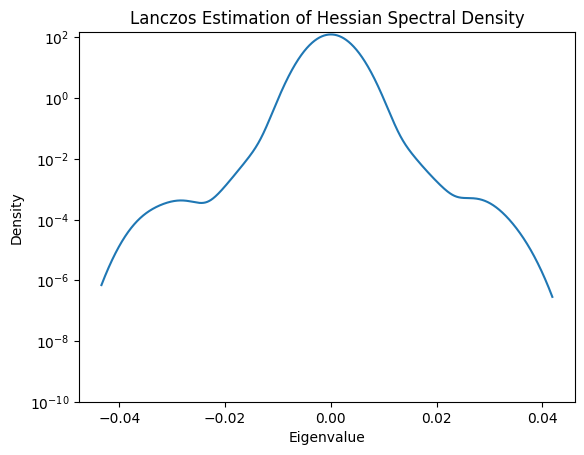

In [25]:
def plot(grids, density, label=None):
  plt.semilogy(grids, density, label=label)
  plt.ylim(1e-10, 1.5e2)
  plt.ylabel("Density")
  plt.xlabel("Eigenvalue")
  plt.title("Lanczos Estimation of Hessian Spectral Density")
  # plt.legend()
plot(grids, density) # 30 epochs no BN

In [26]:
# validate with full hessian - SLOW. will easily hit OOM on anything but the most toy model

# hessian = hessian_computation.full_hessian(loss, params)

